In [2]:
# BASE
import numpy as np
import pandas as pd
import math

# VISUALS
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import panel as pn
pn.extension("tabulator")
import plotly.express as px
import statsmodels.api as sm

In [3]:
from google.colab import drive
drive.mount('/drive')

data_path = "/drive/My Drive/Burak data"

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [4]:
def get_csv(name):
  full_path = '%s/%s.csv' % (data_path, name)
  print('Reading', full_path)
  return pd.read_csv(full_path, encoding='unicode_escape')

# Read all datasets
property_sales = get_csv('property_sales')
immigrants = get_csv('Immigrants(thousand)')
private_households = get_csv('Private households')
persons_private_households = get_csv('Persons in private households')
household_values = get_csv('Household debt, loans and debt securities (Percent of GDP).xls - HH_LS').T.reset_index()
investment_country = get_csv('Direct Investment In Country (Millions of US Dollars).xls - DirectIn').T.reset_index()
gdp_growth = get_csv('Real GDP growth (Annual percent change).xls - NGDP_RPCH').T.reset_index()
gdp_values = get_csv('GDP per capita, current prices (Purchasing power parity; international dollars per capita).xls - PPPPC').T.reset_index()
population = get_csv('Population (Millions of people).xls - LP').T.reset_index()
infliation = get_csv('Inflation rate, average consumer prices (Annual percent change).xls - PCPIPCH').T.reset_index()
unemployment = get_csv('Unemployment rate (Percent).xls - LUR').T.reset_index()

Reading /drive/My Drive/Burak data/property_sales.csv
Reading /drive/My Drive/Burak data/Immigrants(thousand).csv
Reading /drive/My Drive/Burak data/Private households.csv
Reading /drive/My Drive/Burak data/Persons in private households.csv
Reading /drive/My Drive/Burak data/Household debt, loans and debt securities (Percent of GDP).xls - HH_LS.csv
Reading /drive/My Drive/Burak data/Direct Investment In Country (Millions of US Dollars).xls - DirectIn.csv
Reading /drive/My Drive/Burak data/Real GDP growth (Annual percent change).xls - NGDP_RPCH.csv
Reading /drive/My Drive/Burak data/GDP per capita, current prices (Purchasing power parity; international dollars per capita).xls - PPPPC.csv
Reading /drive/My Drive/Burak data/Population (Millions of people).xls - LP.csv
Reading /drive/My Drive/Burak data/Inflation rate, average consumer prices (Annual percent change).xls - PCPIPCH.csv
Reading /drive/My Drive/Burak data/Unemployment rate (Percent).xls - LUR.csv


In [5]:
# Prints a short analysis for dataset and its columns
def dataset_analysis(df):
  print('Dataset Shape:', df.shape)
  print('Dataset number of null values:', df.isnull().sum().sum())
  print('Dataset Columns:')
  for col in df.columns:
    is_numeric = str(df[col].dtype) in ['float64', 'int64']
    if is_numeric:
      values_str = 'Min: %.1f, Mean: %.1f, Max: %.1f' % (df[col].min(), df[col].mean(), df[col].max())
    else:
      values_str = 'Values: %s' % str(df[col].unique())
    print('\tColumn: %s, %s, %s' % (col, 'Numeric' if is_numeric else 'Not Numeric', values_str))

In [6]:
# Counties in scope
COUNTIES = ['Carlow', 'Cavan', 'Clare', 'Cork', 'Donegal', 'Dublin', 'Galway',
            'Kerry', 'Kildare', 'Kilkenny', 'Laois', 'Leitrim', 'Limerick',
            'Longford', 'Louth', 'Mayo', 'Meath', 'Monaghan', 'Offaly',
            'Roscommon', 'Sligo', 'Tipperary', 'Waterford', 'Westmeath',
            'Wexford', 'Wicklow']

## Propety Sales Dataset

In [7]:
dataset_analysis(property_sales)
property_sales.sample(10)

Dataset Shape: (612233, 6)
Dataset number of null values: 0
Dataset Columns:
	Column: Unnamed: 0, Numeric, Min: 0.0, Mean: 306116.0, Max: 612232.0
	Column: Full Date, Not Numeric, Values: ['23/12/2010' '22/12/2010' '21/12/2010' ... '06/02/2023' '17/06/2023'
 '25/03/2023']
	Column: Year, Numeric, Min: 2010.0, Mean: 2017.5, Max: 2023.0
	Column: County, Not Numeric, Values: ['Carlow' 'Cavan' 'Clare' 'Cork' 'Donegal' 'Dublin' 'Galway' 'Kerry'
 'Kildare' 'Kilkenny' 'Laois' 'Leitrim' 'Limerick' 'Longford' 'Louth'
 'Mayo' 'Meath' 'Monaghan' 'Offaly' 'Roscommon' 'Sligo' 'Tipperary'
 'Waterford' 'Westmeath' 'Wexford' 'Wicklow']
	Column: Price, Numeric, Min: 5001.0, Mean: 283461.4, Max: 182378854.0
	Column: Full Address, Not Numeric, Values: ['108 Browneshill Wood, Browneshill Road, Carlow, Carlow'
 '41 Gort Na Greine, Ballinabranna, Carlow'
 '84 Sandhills, Hacketstown Road, Carlow' ...
 '12 PUTLAND VILLAS, VEVAY RD, BRAY, A98X7Y0</a'
 '33 LA VALLEE, UPPER DARGLE RD, FASSAROE, A98X971</a'
 'SCHO

,Unnamed: 0,Full Date,Year,County,Price,Full Address
92384,92384,14/01/2013,2013,Waterford,50000,"3 Moloneys Stores, Lower Main Street, Dungarvan"
194730,194730,29/02/2016,2016,Cork,120000,"CUMEEN, CARRIGALINE, CO. CORK"
239670,239670,20/12/2017,2017,Cork,220000,"COOLBAWN, Garrylucas, Garretstown"
40453,40453,11/05/2012,2012,Clare,65000,"64 Moore Bay, Kilkee, Clare"
558341,558341,22/11/2022,2022,Mayo,98000,"33 THOMAS ST, KILTIMAGH, MAYO, F12CX38</a"
95775,95775,13/08/2014,2014,Cavan,65000,"CLIFFEN, KILLINKERE, CO CAVAN"
385274,385274,15/04/2019,2019,Kildare,169000,"63 LOUGHMINANE GREEN, KILDARE, KILDARE"
269148,269148,16/02/2017,2017,Kerry,100000,"FERMOYLE, BALLINASKELLIGS"
512961,512961,16/06/2021,2021,Wicklow,95000,"33 CORBALLIS DRIVE, RATHDRUM CO WICKLOW"
402285,402285,15/02/2019,2019,Waterford,72500,"APT 1 THE MILL, CONVENT STREET, TALLOW"


In [8]:
# According to month part of the full date, create a quarter number column
property_sales['QuarterNumber'] = property_sales.apply(lambda row: int((int(row['Full Date'].split('/')[1])+2)//3), axis=1)

# Format Year and QuarterNumber columns in Year-Qurter format
property_sales['Quarter'] = property_sales.apply(lambda row: '%d-Q%d' % (int(row['Year']), int(row['QuarterNumber'])), axis=1)

property_sales.sample(5)

,Unnamed: 0,Full Date,Year,County,Price,Full Address,QuarterNumber,Quarter
13306,13306,12/04/2010,2010,Kildare,266000,"3 NEWTOWN HEATH, NEWTOWN MANOR, KILL, Kildare",2,2010-Q2
557995,557995,17/02/2022,2022,Louth,160000,"37 BROOKVILLE PARK, DROGHEDA, LOUTH, A92FFY0</a",1,2022-Q1
71927,71927,12/12/2013,2013,Dublin,249000,"38 MEADOWBROOK AVE, BALDOYLE, DUBLIN 13",4,2013-Q4
230904,230904,27/05/2016,2016,Tipperary,126500,"1 IKERRIN COURT, THURLES, TIPPERARY",2,2016-Q2
588309,588309,02/08/2023,2023,Dublin,335000,"49 BOROIMHE CHERRY, BOROIMHE, SWORDS, K67YP83</a",3,2023-Q3


In [9]:
# Drop columns that won't be grouped
property_sales = property_sales.drop(['Unnamed: 0', 'Full Date', 'Year', 'QuarterNumber', 'Full Address'], axis=1)

# Creates a percentile aggregation function
def percentile(percent):
  return lambda row: row.quantile(percent / 100)

# Aggregate all sales in a County in that quarter
property_sales = property_sales.groupby(['Quarter', 'County']).aggregate(['count', 'min', 'mean', 'max', 'median', percentile(25), percentile(75), percentile(90)])

# Reset grouped columns into columns again
property_sales = property_sales.reset_index()

# Remove multi index
property_sales.columns = ['_'.join([c for c in col_names if len(c) > 0]) for col_names in property_sales.columns.values]

# Rename percentile columns
property_sales = property_sales.rename(columns={
    'Price_<lambda_0>': 'Price_25p',
    'Price_<lambda_1>': 'Price_75p',
    'Price_<lambda_2>': 'Price_90p',
})

property_sales.sample(5)

,Quarter,County,Price_count,Price_min,Price_mean,Price_max,Price_median,Price_25p,Price_75p,Price_90p
667,2016-Q2,Monaghan,91,11667,107976.428571,298000,100000.0,50000.0,158500.0,195000.0
807,2017-Q4,Cavan,240,15000,137482.258333,606322,130000.0,70000.0,185000.0,250500.0
1443,2023-Q4,Mayo,104,22500,200878.384615,770000,180000.0,124750.0,234375.0,334318.8
13,2010-Q1,Longford,26,70485,147357.000000,315000,144889.5,95000.0,169350.0,230000.0
620,2015-Q4,Waterford,379,15000,134386.773087,700000,110500.0,60000.0,175000.0,260000.0


## Immigration Dataset

In [10]:
dataset_analysis(immigrants)
immigrants.sample(10)

Dataset Shape: (14, 5)
Dataset number of null values: 0
Dataset Columns:
	Column: ï»¿STATISTIC Label, Not Numeric, Values: ['Annual Population Change']
	Column: Year, Numeric, Min: 2010.0, Mean: 2016.5, Max: 2023.0
	Column: Component, Not Numeric, Values: ['Immigrants']
	Column: UNIT, Not Numeric, Values: ['Thousand']
	Column: VALUE, Numeric, Min: 41.8, Mean: 82.0, Max: 141.6


,ï»¿STATISTIC Label,Year,Component,UNIT,VALUE
6,Annual Population Change,2016,Immigrants,Thousand,82.3
2,Annual Population Change,2012,Immigrants,Thousand,57.3
5,Annual Population Change,2015,Immigrants,Thousand,75.9
3,Annual Population Change,2013,Immigrants,Thousand,62.7
10,Annual Population Change,2020,Immigrants,Thousand,95.6
12,Annual Population Change,2022,Immigrants,Thousand,107.8
11,Annual Population Change,2021,Immigrants,Thousand,74.1
1,Annual Population Change,2011,Immigrants,Thousand,53.3
0,Annual Population Change,2010,Immigrants,Thousand,41.8
4,Annual Population Change,2014,Immigrants,Thousand,66.5


In [11]:
# We only need Year and Immigrant value from this dataset
# Since unit is Thousand, multiplying value by 1000, and making Year column as index
immigrants = immigrants[['VALUE', 'Year']]
immigrants['VALUE'] = immigrants['VALUE'] * 1000
immigrants.sample(5)

<ipython-input-11-743ecf868a2d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  immigrants['VALUE'] = immigrants['VALUE'] * 1000


,VALUE,Year
2,57300.0,2012
4,66500.0,2014
3,62700.0,2013
5,75900.0,2015
1,53300.0,2011


## Private Households dataset

In [12]:
dataset_analysis(private_households)
private_households.sample(10)

Dataset Shape: (93, 5)
Dataset number of null values: 0
Dataset Columns:
	Column: ï»¿"Statistic Label", Not Numeric, Values: ['Private households']
	Column: CensusYear, Numeric, Min: 2011.0, Mean: 2016.3, Max: 2022.0
	Column: County and City, Not Numeric, Values: ['State' 'Carlow' 'Dublin City' 'DÃºn Laoghaire-Rathdown' 'Fingal'
 'South Dublin' 'Kildare' 'Kilkenny' 'Laois' 'Longford' 'Louth' 'Meath'
 'Offaly' 'Westmeath' 'Wexford' 'Wicklow' 'Clare'
 'Cork City and Cork County' 'Kerry' 'Limerick City and County'
 'Tipperary' 'Waterford City and County' 'Galway City' 'Galway County'
 'Leitrim' 'Mayo' 'Roscommon' 'Sligo' 'Cavan' 'Donegal' 'Monaghan']
	Column: UNIT, Not Numeric, Values: ['Number']
	Column: VALUE, Numeric, Min: 12308.0, Mean: 111777.4, Max: 1841152.0


,"ï»¿""Statistic Label""",CensusYear,County and City,UNIT,VALUE
62,Private households,2022,State,Number,1841152
14,Private households,2011,Wexford,Number,52652
70,Private households,2022,Laois,Number,31232
36,Private households,2016,South Dublin,Number,92523
51,Private households,2016,Tipperary,Number,59276
2,Private households,2011,Dublin City,Number,208008
27,Private households,2011,Sligo,Number,24525
89,Private households,2022,Sligo,Number,26855
82,Private households,2022,Tipperary,Number,62232
66,Private households,2022,Fingal,Number,107846


In [13]:
# We analyse by county, so removing cities from this dataset
private_households['County and City'] = private_households['County and City'].apply(lambda value: {
    'Cork City and Cork County': 'Cork',
    'Dublin City': 'Dublin',
    'DÃºn Laoghaire-Rathdown': 'Dublin',
    'Galway City': 'Galway',
    'Limerick City and County': 'Limerick',
    'South Dublin': 'Dublin',
    'Waterford City and County': 'Waterford'
}.get(value, value))

# Filter down for counties in scope
private_households = private_households[private_households['County and City'].isin(COUNTIES)]

# Rename columns
private_households = private_households.rename(columns={
    'CensusYear': 'Year',
    'County and City': 'County',
})

private_households = private_households[['County', 'Year', 'VALUE']]
private_households.sample(5)

,County,Year,VALUE
13,Westmeath,2011,30739
68,Kildare,2022,82793
34,Dublin,2016,78601
49,Kerry,2016,54493
15,Wicklow,2011,47798


## Persons in Private Households

In [14]:
dataset_analysis(persons_private_households)
persons_private_households.sample(10)

Dataset Shape: (93, 5)
Dataset number of null values: 0
Dataset Columns:
	Column: ï»¿"Statistic Label", Not Numeric, Values: ['Persons in private households']
	Column: CensusYear, Numeric, Min: 2011.0, Mean: 2016.3, Max: 2022.0
	Column: County and City, Not Numeric, Values: ['State' 'Carlow' 'Dublin City' 'DÃºn Laoghaire-Rathdown' 'Fingal'
 'South Dublin' 'Kildare' 'Kilkenny' 'Laois' 'Longford' 'Louth' 'Meath'
 'Offaly' 'Westmeath' 'Wexford' 'Wicklow' 'Clare'
 'Cork City and Cork County' 'Kerry' 'Limerick City and County'
 'Tipperary' 'Waterford City and County' 'Galway City' 'Galway County'
 'Leitrim' 'Mayo' 'Roscommon' 'Sligo' 'Cavan' 'Donegal' 'Monaghan']
	Column: UNIT, Not Numeric, Values: ['Number']
	Column: VALUE, Numeric, Min: 31556.0, Mean: 306101.9, Max: 5046681.0


,"ï»¿""Statistic Label""",CensusYear,County and City,UNIT,VALUE
28,Persons in private households,2011,Cavan,Number,72625
14,Persons in private households,2011,Wexford,Number,144349
25,Persons in private households,2011,Mayo,Number,128492
51,Persons in private households,2016,Tipperary,Number,158933
63,Persons in private households,2022,Carlow,Number,61546
41,Persons in private households,2016,Louth,Number,127751
45,Persons in private households,2016,Wexford,Number,148331
44,Persons in private households,2016,Westmeath,Number,87887
76,Persons in private households,2022,Wexford,Number,161526
35,Persons in private households,2016,Fingal,Number,292989


In [15]:
# We analyse by county, so removing cities from this dataset
persons_private_households['County and City'] = persons_private_households['County and City'].apply(lambda value: {
    'Cork City and Cork County': 'Cork',
    'Dublin City': 'Dublin',
    'DÃºn Laoghaire-Rathdown': 'Dublin',
    'Galway City': 'Galway',
    'Limerick City and County': 'Limerick',
    'South Dublin': 'Dublin',
    'Waterford City and County': 'Waterford'
}.get(value, value))

# Filter down for counties in scope
persons_private_households = persons_private_households[persons_private_households['County and City'].isin(COUNTIES)]

# Rename columns
persons_private_households = persons_private_households.rename(columns={
    'CensusYear': 'Year',
    'County and City': 'County',
})

persons_private_households = persons_private_households[['County', 'Year', 'VALUE']]
persons_private_households.sample(5)

,County,Year,VALUE
76,Wexford,2022,161526
91,Donegal,2022,164501
33,Dublin,2016,525229
92,Monaghan,2022,64429
90,Cavan,2022,80749


## Household debt, loans and debt security values

In [16]:
dataset_analysis(household_values)
household_values.head()

Dataset Shape: (74, 5)
Dataset number of null values: 221
Dataset Columns:
	Column: index, Not Numeric, Values: ['Household debt, loans and debt securities (Percent of GDP)' '1950'
 '1951' '1952' '1953' '1954' '1955' '1956' '1957' '1958' '1959' '1960'
 '1961' '1962' '1963' '1964' '1965' '1966' '1967' '1968' '1969' '1970'
 '1971' '1972' '1973' '1974' '1975' '1976' '1977' '1978' '1979' '1980'
 '1981' '1982' '1983' '1984' '1985' '1986' '1987' '1988' '1989' '1990'
 '1991' '1992' '1993' '1994' '1995' '1996' '1997' '1998' '1999' '2000'
 '2001' '2002' '2003' '2004' '2005' '2006' '2007' '2008' '2009' '2010'
 '2011' '2012' '2013' '2014' '2015' '2016' '2017' '2018' '2019' '2020'
 '2021' '2022']
	Column: 0, Not Numeric, Values: [nan]
	Column: 1, Not Numeric, Values: ['Ireland' 'no data' 51.3566376 58.25027305 69.72334394 81.05057955
 91.5734712 97.56634698 107.9222353 117.5626331 112.3034554 106.0115782
 98.10836204 92.81276295 80.39213676 55.7731504 52.74864363 46.67201768
 41.797931 37.51783687

,index,0,1,2,3
0,"Household debt, loans and debt securities (Per...",NaN,Ireland,NaN,"Â©IMF, 2023"
1,1950,NaN,no data,NaN,NaN
2,1951,NaN,no data,NaN,NaN
3,1952,NaN,no data,NaN,NaN
4,1953,NaN,no data,NaN,NaN


In [17]:
# Drop first row
household_values = household_values.drop(0)

# Column names
household_values.columns = ['Year', 'empty1', 'VALUE', 'empty2', 'empty3']

# Filter columns
household_values = household_values[['Year', 'VALUE']]

# Filter down that has data
household_values = household_values[household_values['VALUE'] != 'no data']

# Change column type
household_values['Year'] = household_values['Year'].astype(int)
household_values['VALUE'] = household_values['VALUE'].astype(int)

household_values.sample(5)

,Year,VALUE
55,2004,69
71,2020,35
70,2019,37
66,2015,55
68,2017,46


## Investment In Country

In [18]:
dataset_analysis(investment_country)
investment_country.head()

Dataset Shape: (21, 5)
Dataset number of null values: 62
Dataset Columns:
	Column: index, Not Numeric, Values: ['Direct Investment In Country (Millions of US Dollars)' '1995' '1996'
 '1997' '1998' '1999' '2000' '2001' '2002' '2003' '2004' '2005' '2006'
 '2007' '2008' '2009' '2010' '2011' '2012' '2013' '2014']
	Column: 0, Not Numeric, Values: [nan]
	Column: 1, Not Numeric, Values: ['Ireland' 1446.53 2617.95 2742.87 11034.67 18322.77 34791.75 11938.48
 40018.56 55412.01 35656.15 47028.46 22080.94 59941.05 23258.56 53935.26
 37763.64 23664.92 40961.64 49960.14 86765.62]
	Column: 2, Not Numeric, Values: [nan]
	Column: 3, Not Numeric, Values: ['Â©IMF, 2023' nan]


,index,0,1,2,3
0,Direct Investment In Country (Millions of US D...,NaN,Ireland,NaN,"Â©IMF, 2023"
1,1995,NaN,1446.53,NaN,NaN
2,1996,NaN,2617.95,NaN,NaN
3,1997,NaN,2742.87,NaN,NaN
4,1998,NaN,11034.67,NaN,NaN


In [19]:
# Drop first row
investment_country = investment_country.drop(0)

# Column names
investment_country.columns = ['Year', 'empty1', 'VALUE', 'empty2', 'empty3']

# Filter columns
investment_country = investment_country[['Year', 'VALUE']]

# Unit is Millions of US Dollars
investment_country['VALUE'] = investment_country['VALUE'] * 1000000

# Change column type
investment_country['Year'] = investment_country['Year'].astype(int)
investment_country['VALUE'] = investment_country['VALUE'].astype(int)

investment_country.sample(5)

,Year,VALUE
8,2002,40018560000
14,2008,23258560000
20,2014,86765620000
16,2010,37763640000
6,2000,34791750000


## GDP Growth

In [20]:
dataset_analysis(gdp_growth)
gdp_growth.head()

Dataset Shape: (50, 5)
Dataset number of null values: 149
Dataset Columns:
	Column: index, Not Numeric, Values: ['Real GDP growth (Annual percent change)' '1980' '1981' '1982' '1983'
 '1984' '1985' '1986' '1987' '1988' '1989' '1990' '1991' '1992' '1993'
 '1994' '1995' '1996' '1997' '1998' '1999' '2000' '2001' '2002' '2003'
 '2004' '2005' '2006' '2007' '2008' '2009' '2010' '2011' '2012' '2013'
 '2014' '2015' '2016' '2017' '2018' '2019' '2020' '2021' '2022' '2023'
 '2024' '2025' '2026' '2027' '2028']
	Column: 0, Not Numeric, Values: [nan]
	Column: 1, Not Numeric, Values: ['Ireland' 2.9 2.5 1.5 -0.7 3.2 1.9 0.4 3.6 3.0 5.6 7.7 1.6 2.3 5.9 9.6
 9.1 10.7 8.8 10.5 9.4 5.3 6.8 5.7 5.0 -4.5 -5.1 1.7 1.3 -0.1 1.2 24.5 1.8
 9.3 8.5 6.6 15.1 2.0 3.3 2.7]
	Column: 2, Not Numeric, Values: [nan]
	Column: 3, Not Numeric, Values: ['Â©IMF, 2023' nan]


,index,0,1,2,3
0,Real GDP growth (Annual percent change),NaN,Ireland,NaN,"Â©IMF, 2023"
1,1980,NaN,2.9,NaN,NaN
2,1981,NaN,2.5,NaN,NaN
3,1982,NaN,1.5,NaN,NaN
4,1983,NaN,-0.7,NaN,NaN


In [21]:
# Drop first row
gdp_growth = gdp_growth.drop(0)

# Column names
gdp_growth.columns = ['Year', 'empty1', 'VALUE0', 'empty2', 'empty3']

# Filter columns
gdp_growth = gdp_growth[['Year', 'VALUE0']]

# Change column type
gdp_growth['Year'] = gdp_growth['Year'].astype(int)
gdp_growth['VALUE0'] = gdp_growth['VALUE0'].astype(int)

gdp_growth.sample(5)

,Year,VALUE0
38,2017,9
6,1985,1
29,2008,-4
14,1993,2
27,2006,5


In [22]:
# Create dictionary for year and value
gdp_growth_percents = {year: percent for year, percent in zip(gdp_growth['Year'], gdp_growth['VALUE0'])}

# GDP by base (assuming 1980 was 1000)
gdp_based = {1980: 1000}

for y in sorted(gdp_growth['Year']):
  gdp_based[y + 1] = gdp_based[y] + gdp_based[y] * gdp_growth_percents[y] / 100

gdp_growth['VALUE1'] = gdp_growth['Year'].apply(lambda y: gdp_based[y]).astype(float)
gdp_growth.sample(5)

,Year,VALUE0,VALUE1
27,2006,5,3105.099477
49,2028,2,8044.973374
41,2020,6,5377.983220
19,1998,8,1897.237029
15,1994,5,1382.568355


## GDP per capita with purchasing power parity

In [23]:
dataset_analysis(gdp_values)
gdp_values.head()

Dataset Shape: (50, 5)
Dataset number of null values: 149
Dataset Columns:
	Column: index, Not Numeric, Values: ['GDP per capita, current prices (Purchasing power parity; international dollars per capita)'
 '1980' '1981' '1982' '1983' '1984' '1985' '1986' '1987' '1988' '1989'
 '1990' '1991' '1992' '1993' '1994' '1995' '1996' '1997' '1998' '1999'
 '2000' '2001' '2002' '2003' '2004' '2005' '2006' '2007' '2008' '2009'
 '2010' '2011' '2012' '2013' '2014' '2015' '2016' '2017' '2018' '2019'
 '2020' '2021' '2022' '2023' '2024' '2025' '2026' '2027' '2028']
	Column: 0, Not Numeric, Values: [nan]
	Column: 1, Not Numeric, Values: ['Ireland' 7362.645 8159.941 8701.151 8914.454 9464.638 9923.119 10164.11
 10776.764 11542.685 12745.298 14256.81 14896.37 15653.346 16305.232
 17577.013 19582.999 21605.842 24086.707 26215.161 29054.141 32040.558
 33968.414 35908.917 37111.456 39915.513 42492.628 44701.545 46998.295
 45032.601 42716.886 43756.065 45072.58 46230.701 47727.674 51132.925
 69057.156 71164.1

,index,0,1,2,3
0,"GDP per capita, current prices (Purchasing pow...",NaN,Ireland,NaN,"Â©IMF, 2023"
1,1980,NaN,7362.645,NaN,NaN
2,1981,NaN,8159.941,NaN,NaN
3,1982,NaN,8701.151,NaN,NaN
4,1983,NaN,8914.454,NaN,NaN


In [24]:
# Drop first row
gdp_values = gdp_values.drop(0)

# Column names
gdp_values.columns = ['Year', 'empty1', 'VALUE', 'empty2', 'empty3']

# Filter columns
gdp_values = gdp_values[['Year', 'VALUE']]

# Change column type
gdp_values['Year'] = gdp_values['Year'].astype(int)
gdp_values['VALUE'] = gdp_values['VALUE'].astype(float)

gdp_values.sample(5)

,Year,VALUE
43,2022,132359.039
3,1982,8701.151
42,2021,115885.370
31,2010,43756.065
23,2002,35908.917


## Population

In [25]:
dataset_analysis(population)
population.head()

Dataset Shape: (50, 5)
Dataset number of null values: 149
Dataset Columns:
	Column: index, Not Numeric, Values: ['Population (Millions of people)' '1980' '1981' '1982' '1983' '1984'
 '1985' '1986' '1987' '1988' '1989' '1990' '1991' '1992' '1993' '1994'
 '1995' '1996' '1997' '1998' '1999' '2000' '2001' '2002' '2003' '2004'
 '2005' '2006' '2007' '2008' '2009' '2010' '2011' '2012' '2013' '2014'
 '2015' '2016' '2017' '2018' '2019' '2020' '2021' '2022' '2023' '2024'
 '2025' '2026' '2027' '2028']
	Column: 0, Not Numeric, Values: [nan]
	Column: 1, Not Numeric, Values: ['Ireland' 3.427 3.47 3.507 3.531 3.556 3.567 3.568 3.574 3.558 3.536
 3.533 3.553 3.582 3.601 3.613 3.629 3.654 3.692 3.731 3.774 3.829 3.889
 3.956 4.021 4.1 4.2 4.321 4.445 4.516 4.547 4.568 4.585 4.605 4.631 4.667
 4.714 4.771 4.825 4.886 4.949 4.992 5.037 5.165 5.252 5.336 5.395 5.454
 5.514 5.575]
	Column: 2, Not Numeric, Values: [nan]
	Column: 3, Not Numeric, Values: ['Â©IMF, 2023' nan]


,index,0,1,2,3
0,Population (Millions of people),NaN,Ireland,NaN,"Â©IMF, 2023"
1,1980,NaN,3.427,NaN,NaN
2,1981,NaN,3.47,NaN,NaN
3,1982,NaN,3.507,NaN,NaN
4,1983,NaN,3.531,NaN,NaN


In [26]:
# Drop first row
population = population.drop(0)

# Column names
population.columns = ['Year', 'empty1', 'VALUE', 'empty2', 'empty3']

# Filter columns
population = population[['Year', 'VALUE']]

# Unit is Millions of people
population['VALUE'] = population['VALUE'] * 1000000

# Change column type
population['Year'] = population['Year'].astype(int)
population['VALUE'] = population['VALUE'].astype(int)

population.sample(5)

,Year,VALUE
46,2025,5395000
37,2016,4771000
31,2010,4568000
21,2000,3829000
36,2015,4714000


## Inflation rate

In [27]:
dataset_analysis(infliation)
infliation.head()

Dataset Shape: (50, 5)
Dataset number of null values: 149
Dataset Columns:
	Column: index, Not Numeric, Values: ['Inflation rate, average consumer prices (Annual percent change)' '1980'
 '1981' '1982' '1983' '1984' '1985' '1986' '1987' '1988' '1989' '1990'
 '1991' '1992' '1993' '1994' '1995' '1996' '1997' '1998' '1999' '2000'
 '2001' '2002' '2003' '2004' '2005' '2006' '2007' '2008' '2009' '2010'
 '2011' '2012' '2013' '2014' '2015' '2016' '2017' '2018' '2019' '2020'
 '2021' '2022' '2023' '2024' '2025' '2026' '2027' '2028']
	Column: 0, Not Numeric, Values: [nan]
	Column: 1, Not Numeric, Values: ['Ireland' 18.3 20.2 17.2 10.4 8.6 5.5 3.0 3.2 2.2 4.0 3.4 3.1 1.4 2.4 2.5
 1.3 2.1 5.3 4.7 2.3 2.7 2.9 -1.7 -1.6 1.2 1.9 0.5 0.3 0.0 -0.2 0.7 0.9
 -0.5 8.1 5.2 2.0]
	Column: 2, Not Numeric, Values: [nan]
	Column: 3, Not Numeric, Values: ['Â©IMF, 2023' nan]


,index,0,1,2,3
0,"Inflation rate, average consumer prices (Annua...",NaN,Ireland,NaN,"Â©IMF, 2023"
1,1980,NaN,18.3,NaN,NaN
2,1981,NaN,20.2,NaN,NaN
3,1982,NaN,17.2,NaN,NaN
4,1983,NaN,10.4,NaN,NaN


In [28]:
# Drop first row
infliation = infliation.drop(0)

# Column names
infliation.columns = ['Year', 'empty1', 'VALUE0', 'empty2', 'empty3']

# Filter columns
infliation = infliation[['Year', 'VALUE0']]

# Change column type
infliation['Year'] = infliation['Year'].astype(int)
infliation['VALUE0'] = infliation['VALUE0'].astype(float)

infliation.sample(5)

,Year,VALUE0
42,2021,2.4
40,2019,0.9
23,2002,4.7
49,2028,2.0
33,2012,1.9


In [29]:
# Create dictionary for year and value
infliation_percents = {year: percent for year, percent in zip(infliation['Year'], infliation['VALUE0'])}

# Infliation by base (assuming 1980 was 1000)
infliation_based = {1980: 1000}

for y in sorted(infliation['Year']):
  infliation_based[y + 1] = infliation_based[y] + infliation_based[y] * infliation_percents[y] / 100

infliation['VALUE1'] = infliation['Year'].apply(lambda y: infliation_based[y]).astype(float)
infliation.sample(5)

,Year,VALUE0,VALUE1
4,1983,10.4,1666.544152
26,2005,2.2,3678.513809
28,2007,2.9,3860.946023
7,1986,3.0,2107.988233
11,1990,3.4,2381.602839


## Unemployment percent

In [30]:
dataset_analysis(unemployment)
unemployment.head()

Dataset Shape: (50, 5)
Dataset number of null values: 149
Dataset Columns:
	Column: index, Not Numeric, Values: ['Unemployment rate (Percent)' '1980' '1981' '1982' '1983' '1984' '1985'
 '1986' '1987' '1988' '1989' '1990' '1991' '1992' '1993' '1994' '1995'
 '1996' '1997' '1998' '1999' '2000' '2001' '2002' '2003' '2004' '2005'
 '2006' '2007' '2008' '2009' '2010' '2011' '2012' '2013' '2014' '2015'
 '2016' '2017' '2018' '2019' '2020' '2021' '2022' '2023' '2024' '2025'
 '2026' '2027' '2028']
	Column: 0, Not Numeric, Values: [nan]
	Column: 1, Not Numeric, Values: ['Ireland' 'no data' 17.7 18.1 18.8 18.4 17.9 17.2 19.0 16.3 16.7 15.1
 14.1 11.8 9.9 7.6 5.9 4.4 4.2 4.7 4.9 4.8 4.6 5.0 6.8 12.7 14.6 15.4 15.5
 13.8 11.9 8.4 5.8 6.3 4.5 4.1]
	Column: 2, Not Numeric, Values: [nan]
	Column: 3, Not Numeric, Values: ['Â©IMF, 2023' nan]


,index,0,1,2,3
0,Unemployment rate (Percent),NaN,Ireland,NaN,"Â©IMF, 2023"
1,1980,NaN,no data,NaN,NaN
2,1981,NaN,no data,NaN,NaN
3,1982,NaN,no data,NaN,NaN
4,1983,NaN,no data,NaN,NaN


In [31]:
# Drop first row
unemployment = unemployment.drop(0)

# Column names
unemployment.columns = ['Year', 'empty1', 'VALUE0', 'empty2', 'empty3']

# Filter columns
unemployment = unemployment[['Year', 'VALUE0']]

# Filter down that has data
unemployment = unemployment[unemployment['VALUE0'] != 'no data']

# Change column type
unemployment['Year'] = unemployment['Year'].astype(int)
unemployment['VALUE0'] = unemployment['VALUE0'].astype(float)

unemployment.sample(5)

,Year,VALUE0
37,2016,8.4
10,1989,17.9
31,2010,14.6
17,1996,11.8
41,2020,5.8


In [32]:
# Create dictionary for year and value
unemployment_percents = {year: percent for year, percent in zip(unemployment['Year'], unemployment['VALUE0'])}

# Unemployment by base (assuming 1985 was 1000)
unemployment_based = {1985: 1000}

for y in sorted(unemployment['Year']):
  unemployment_based[y + 1] = unemployment_based[y] + unemployment_based[y] * unemployment_percents[y] / 100

unemployment['VALUE1'] = unemployment['Year'].apply(lambda y: unemployment_based[y]).astype(float)
unemployment.sample(5)

,Year,VALUE0,VALUE1
37,2016,8.4,29751.831431
11,1990,17.2,2305.198395
20,1999,5.9,7576.108536
22,2001,4.2,8376.115293
29,2008,6.8,11563.147999


## Merging fixed datasets into single dataset

In [33]:
# Property sales already have Quarter and County columns, using it as base merged dataset
merged_dataset = property_sales.copy()

merged_dataset.sample(5)

,Quarter,County,Price_count,Price_min,Price_mean,Price_max,Price_median,Price_25p,Price_75p,Price_90p
384,2013-Q3,Sligo,104,15000,113778.557692,355000,92000.0,53750.0,158500.0,230579.2
1191,2021-Q2,Tipperary,334,6435,162105.137725,570000,149750.0,90250.0,210000.0,278800.0
35,2010-Q2,Kilkenny,95,30000,200949.147368,730000,175500.0,129997.5,249500.0,329800.0
99,2010-Q4,Tipperary,169,7618,151355.360947,410000,140000.0,91800.0,196000.0,273540.0
1319,2022-Q3,Roscommon,151,20000,171742.966887,575000,153000.0,90000.0,224834.5,325000.0


In [34]:
immigrants_per_year = {year: immigrants for year, immigrants in zip(immigrants['Year'], immigrants['VALUE'])}

merged_dataset['immigrants'] = merged_dataset['Quarter'].apply(lambda q: immigrants_per_year.get(int(q.split('-')[0]), None))

merged_dataset.sample(5)

,Quarter,County,Price_count,Price_min,Price_mean,Price_max,Price_median,Price_25p,Price_75p,Price_90p,immigrants
1052,2020-Q1,Limerick,470,7600,212539.585106,2339205,190500.0,110000.0,274250.0,330000.0,95600.0
788,2017-Q3,Kildare,741,10000,261021.500675,2010000,245000.0,178500.0,320000.0,395000.0,95300.0
113,2011-Q1,Kilkenny,69,20000,169187.826087,800000,160000.0,118723.0,205000.0,246301.2,53300.0
955,2019-Q1,Roscommon,181,15000,125780.088398,819000,100000.0,65000.0,162504.0,237000.0,97100.0
448,2014-Q2,Galway,520,10000,150908.373077,1444933,127000.0,72000.0,197625.0,290100.0,66500.0


In [35]:
private_households_per_county = {(county, year): phs for county, year, phs in zip(private_households['County'], private_households['Year'], private_households['VALUE'])}

# Looks like this dataset show values from 2011, 2016, 2022
# Duplicating 2011 values to 2012 to 2015, 2016 values to 2017 to 2021
for cnt in COUNTIES:
  if (cnt, 2011) in private_households_per_county:
    private_households_per_county[(cnt, 2010)] = private_households_per_county[(cnt, 2011)]
    private_households_per_county[(cnt, 2012)] = private_households_per_county[(cnt, 2011)]
    private_households_per_county[(cnt, 2013)] = private_households_per_county[(cnt, 2011)]
    private_households_per_county[(cnt, 2014)] = private_households_per_county[(cnt, 2011)]
    private_households_per_county[(cnt, 2015)] = private_households_per_county[(cnt, 2011)]
  if (cnt, 2016) in private_households_per_county:
    private_households_per_county[(cnt, 2017)] = private_households_per_county[(cnt, 2016)]
    private_households_per_county[(cnt, 2018)] = private_households_per_county[(cnt, 2016)]
    private_households_per_county[(cnt, 2019)] = private_households_per_county[(cnt, 2016)]
    private_households_per_county[(cnt, 2020)] = private_households_per_county[(cnt, 2016)]
    private_households_per_county[(cnt, 2021)] = private_households_per_county[(cnt, 2016)]
  if (cnt, 2022) in private_households_per_county:
    private_households_per_county[(cnt, 2023)] = private_households_per_county[(cnt, 2022)]

merged_dataset['private_households'] = merged_dataset.apply(lambda row: private_households_per_county.get((row['County'], int(row['Quarter'].split('-')[0])), None), axis=1)

merged_dataset.sample(5)

,Quarter,County,Price_count,Price_min,Price_mean,Price_max,Price_median,Price_25p,Price_75p,Price_90p,immigrants,private_households
565,2015-Q2,Roscommon,219,5179,74280.625571,550000,58000.0,23559.00,100000.0,156000.0,75900.0,23672
609,2015-Q4,Leitrim,126,15000,88744.968254,815000,71000.0,40000.00,115000.0,162500.0,75900.0,12308
580,2015-Q3,Kildare,616,17776,258881.803571,6250000,230000.0,157361.75,300000.0,410000.0,75900.0,70763
668,2016-Q2,Offaly,134,11000,134222.589552,834437,120000.0,70000.00,164000.0,237000.0,82300.0,27343
741,2017-Q1,Longford,68,15000,84626.088235,250000,70000.0,40000.00,116325.0,152900.0,95300.0,15122


In [36]:
persons_private_households_per_county = {(county, year): phs for county, year, phs in zip(persons_private_households['County'], persons_private_households['Year'], persons_private_households['VALUE'])}

# Looks like this dataset show values from 2011, 2016, 2022
# Duplicating 2011 values to 2012 to 2015, 2016 values to 2017 to 2021
for cnt in COUNTIES:
  if (cnt, 2011) in persons_private_households_per_county:
    persons_private_households_per_county[(cnt, 2010)] = persons_private_households_per_county[(cnt, 2011)]
    persons_private_households_per_county[(cnt, 2012)] = persons_private_households_per_county[(cnt, 2011)]
    persons_private_households_per_county[(cnt, 2013)] = persons_private_households_per_county[(cnt, 2011)]
    persons_private_households_per_county[(cnt, 2014)] = persons_private_households_per_county[(cnt, 2011)]
    persons_private_households_per_county[(cnt, 2015)] = persons_private_households_per_county[(cnt, 2011)]
  if (cnt, 2016) in persons_private_households_per_county:
    persons_private_households_per_county[(cnt, 2017)] = persons_private_households_per_county[(cnt, 2016)]
    persons_private_households_per_county[(cnt, 2018)] = persons_private_households_per_county[(cnt, 2016)]
    persons_private_households_per_county[(cnt, 2019)] = persons_private_households_per_county[(cnt, 2016)]
    persons_private_households_per_county[(cnt, 2020)] = persons_private_households_per_county[(cnt, 2016)]
    persons_private_households_per_county[(cnt, 2021)] = persons_private_households_per_county[(cnt, 2016)]
  if (cnt, 2022) in persons_private_households_per_county:
    persons_private_households_per_county[(cnt, 2023)] = persons_private_households_per_county[(cnt, 2022)]

merged_dataset['persons_private_households'] = merged_dataset.apply(lambda row: persons_private_households_per_county.get((row['County'], int(row['Quarter'].split('-')[0])), None), axis=1)

merged_dataset.sample(5)

,Quarter,County,Price_count,Price_min,Price_mean,Price_max,Price_median,Price_25p,Price_75p,Price_90p,immigrants,private_households,persons_private_households
137,2011-Q2,Kerry,138,10000,187386.021739,1057268,160000.0,112250.0,225000.0,328450.0,53300.0,53306,140975
562,2015-Q2,Meath,360,15000,191068.216667,600000,178250.0,119448.5,250000.0,328700.0,75900.0,62201,184336
177,2011-Q3,Tipperary,125,20000,131202.456000,400000,115000.0,71000.0,175000.0,239120.0,53300.0,58497,158089
420,2014-Q1,Donegal,182,10000,98464.120879,710000,81933.5,50000.0,120000.0,169500.0,66500.0,57964,159139
304,2012-Q4,Offaly,109,25000,111587.137615,800000,100000.0,63000.0,135000.0,190000.0,57300.0,26750,76274


In [37]:
household_values_per_year = {year: hval for year, hval in zip(household_values['Year'], household_values['VALUE'])}
household_values_per_year[2023] = household_values_per_year[2022]

merged_dataset['household_values'] = merged_dataset['Quarter'].apply(lambda q: household_values_per_year.get(int(q.split('-')[0]), None))

merged_dataset.sample(5)

,Quarter,County,Price_count,Price_min,Price_mean,Price_max,Price_median,Price_25p,Price_75p,Price_90p,immigrants,private_households,persons_private_households,household_values
102,2010-Q4,Wexford,192,10000,176318.546875,522000,155000.0,113473.5,225000.0,282488.8,41800.0,52652,144349,112
56,2010-Q3,Donegal,163,6348,155558.000000,1434000,130792.0,83333.0,180000.0,254000.0,41800.0,57964,159139,112
973,2019-Q2,Leitrim,71,10000,114105.901408,355000,92000.0,70000.0,150500.0,177000.0,97100.0,12452,31721,37
81,2010-Q4,Cork,629,10000,226261.087440,2350000,205000.0,138000.0,264100.0,366000.0,41800.0,188019,512300,112
638,2016-Q1,Louth,239,7250,143478.238494,606250,130000.0,85000.0,172795.0,237885.2,82300.0,45448,127751,52


In [38]:
investment_country_per_year = {year: hval for year, hval in zip(investment_country['Year'], investment_country['VALUE'])}

for y in range(2015, 2024):
  investment_country_per_year[y] = investment_country_per_year[2014]

merged_dataset['investment_country'] = merged_dataset['Quarter'].apply(lambda q: investment_country_per_year.get(int(q.split('-')[0]), None))

merged_dataset.sample(5)

,Quarter,County,Price_count,Price_min,Price_mean,Price_max,Price_median,Price_25p,Price_75p,Price_90p,immigrants,private_households,persons_private_households,household_values,investment_country
1010,2019-Q3,Waterford,432,17500,189601.509259,1910132,175000.0,115000.0,225000.0,305000.0,97100.0,43549,114402,37,86765620000
538,2015-Q1,Offaly,139,25000,105568.395683,530000,85000.0,61330.0,136000.0,175400.0,75900.0,26750,76274,55,86765620000
1383,2023-Q2,Dublin,92,9962,539880.565217,4471815,396000.0,283750.0,591250.0,923599.0,141600.0,100364,298125,26,86765620000
872,2018-Q2,Louth,324,15000,193643.320988,800000,193000.0,135000.0,233480.0,298500.0,96000.0,45448,127751,41,86765620000
167,2011-Q3,Leitrim,47,15000,108462.978723,425000,76651.0,62500.0,135000.0,165800.0,53300.0,12308,31556,106,23664920000


In [39]:
gdp_growth_per_year = {year: gdp for year, gdp in zip(gdp_growth['Year'], gdp_growth['VALUE0'])}
gdp_growth_based_per_year = {year: gdp for year, gdp in zip(gdp_growth['Year'], gdp_growth['VALUE1'])}

merged_dataset['gdp_growth'] = merged_dataset['Quarter'].apply(lambda q: gdp_growth_per_year.get(int(q.split('-')[0]), None))
merged_dataset['gdp_growth_based'] = merged_dataset['Quarter'].apply(lambda q: gdp_growth_based_per_year.get(int(q.split('-')[0]), None))

merged_dataset.sample(5)

,Quarter,County,Price_count,Price_min,Price_mean,Price_max,Price_median,Price_25p,Price_75p,Price_90p,immigrants,private_households,persons_private_households,household_values,investment_country,gdp_growth,gdp_growth_based
11,2010-Q1,Leitrim,18,65000,128986.888889,248000,122500.0,94125.0,140226.75,198500.0,41800.0,12308,31556,112,37763640000,1,3122.115422
945,2019-Q1,Kilkenny,192,24000,195874.968750,485000,178500.0,141500.0,230500.00,327950.0,97100.0,34855,97536,37,86765620000,5,5121.888781
169,2011-Q3,Longford,36,11427,94957.694444,232698,90000.0,45000.0,126250.00,186250.0,53300.0,14453,38986,106,23664920000,1,3153.336576
332,2013-Q1,Sligo,73,10000,87163.890411,385000,75000.0,50000.0,105000.00,150600.0,62700.0,24525,63667,92,49960140000,1,3184.869942
839,2018-Q1,Kerry,389,15000,148307.282776,1900000,132000.0,65000.0,186000.00,246200.0,96000.0,54493,141596,41,86765620000,8,4742.489612


In [40]:
gdp_values_per_year = {year: gdp for year, gdp in zip(gdp_values['Year'], gdp_values['VALUE'])}

merged_dataset['gdp_values'] = merged_dataset['Quarter'].apply(lambda q: gdp_values_per_year.get(int(q.split('-')[0]), None))

merged_dataset.sample(5)

,Quarter,County,Price_count,Price_min,Price_mean,Price_max,Price_median,Price_25p,Price_75p,Price_90p,immigrants,private_households,persons_private_households,household_values,investment_country,gdp_growth,gdp_growth_based,gdp_values
1436,2023-Q4,Kildare,251,57735,376721.111554,1650000,361000.0,283500.00,431719.0,533000.0,141600.0,82793,246285,26,86765620000,2,7145.780084,137638.163
762,2017-Q2,Kildare,649,15000,264239.711864,2300000,251764.0,183000.00,320000.0,400000.0,95300.0,73596,220923,46,86765620000,9,4350.907901,78203.159
488,2014-Q3,Sligo,190,10000,115097.989474,837004,90000.0,52634.25,151425.0,225200.0,66500.0,24525,63667,80,86765620000,8,3216.718642,51132.925
689,2016-Q3,Longford,88,10000,98444.965909,550000,71000.0,43750.00,136875.0,190750.0,82300.0,15122,40775,52,86765620000,1,4307.829605,71164.154
1349,2022-Q4,Westmeath,381,10000,274040.740157,4842600,250000.0,177500.00,313000.0,400000.0,107800.0,34087,94663,26,86765620000,9,6555.761545,132359.039


In [41]:
population_per_year = {year: gdp for year, gdp in zip(population['Year'], population['VALUE'])}

merged_dataset['population'] = merged_dataset['Quarter'].apply(lambda q: population_per_year.get(int(q.split('-')[0]), None))

merged_dataset.sample(5)

,Quarter,County,Price_count,Price_min,Price_mean,Price_max,Price_median,Price_25p,Price_75p,Price_90p,immigrants,private_households,persons_private_households,household_values,investment_country,gdp_growth,gdp_growth_based,gdp_values,population
211,2012-Q1,Cork,484,8570,165658.419421,1050000,150000.0,82640.75,206822.25,297750.0,57300.0,188019,512300,98,40961640000,0,3184.869942,46230.701,4605000
524,2015-Q1,Donegal,336,5334,93171.452381,500000,72000.0,50000.00,115000.00,180000.0,75900.0,57964,159139,55,86765620000,24,3474.056133,69057.156,4714000
998,2019-Q3,Laois,242,13000,180883.260331,540000,170000.0,136050.00,205000.00,270000.0,97100.0,29107,83534,37,86765620000,5,5121.888781,90779.491,4949000
1214,2021-Q3,Offaly,205,36000,190976.819512,584300,170000.0,120000.00,240000.00,308000.0,74100.0,27343,77755,30,86765620000,15,5700.662213,115885.370,5037000
746,2017-Q1,Offaly,140,25000,140981.078571,695000,130000.0,75000.00,165000.00,235500.0,95300.0,27343,77755,46,86765620000,9,4350.907901,78203.159,4825000


In [42]:
infliation_per_year = {year: gdp for year, gdp in zip(infliation['Year'], infliation['VALUE0'])}
infliation_based_per_year = {year: gdp for year, gdp in zip(infliation['Year'], infliation['VALUE1'])}

merged_dataset['infliation'] = merged_dataset['Quarter'].apply(lambda q: infliation_per_year.get(int(q.split('-')[0]), None))
merged_dataset['infliation_based'] = merged_dataset['Quarter'].apply(lambda q: infliation_based_per_year.get(int(q.split('-')[0]), None))

merged_dataset.sample(5)

,Quarter,County,Price_count,Price_min,Price_mean,Price_max,Price_median,Price_25p,Price_75p,Price_90p,...,private_households,persons_private_households,household_values,investment_country,gdp_growth,gdp_growth_based,gdp_values,population,infliation,infliation_based
797,2017-Q3,Monaghan,87,10000,136323.839080,704845,130000.0,69000.0,171000.0,238000.0,...,21689,61328,46,86765620000,9,4350.907901,78203.159,4825000,0.3,4110.253606
1138,2020-Q4,Sligo,250,16000,155827.348000,1006250,123250.0,76000.0,195000.0,285500.0,...,24831,63656,35,86765620000,6,5377.983220,97205.463,4992000,-0.5,4188.805440
254,2012-Q2,Sligo,81,13333,109399.876543,407000,97000.0,65000.0,140000.0,168500.0,...,24525,63667,98,40961640000,0,3184.869942,46230.701,4605000,1.9,4009.561682
309,2012-Q4,Westmeath,149,10000,111063.704698,450000,93000.0,68000.0,140000.0,187100.0,...,30739,84869,98,40961640000,0,3184.869942,46230.701,4605000,1.9,4009.561682
801,2017-Q3,Tipperary,392,9650,148211.505102,1612000,130000.0,75000.0,180000.0,255000.0,...,59276,158933,46,86765620000,9,4350.907901,78203.159,4825000,0.3,4110.253606


In [43]:
unemployment_per_year = {year: gdp for year, gdp in zip(unemployment['Year'], unemployment['VALUE0'])}
unemployment_based_per_year = {year: gdp for year, gdp in zip(unemployment['Year'], unemployment['VALUE1'])}

merged_dataset['unemployment'] = merged_dataset['Quarter'].apply(lambda q: unemployment_per_year.get(int(q.split('-')[0]), None))
merged_dataset['unemployment_based'] = merged_dataset['Quarter'].apply(lambda q: unemployment_based_per_year.get(int(q.split('-')[0]), None))

merged_dataset.sample(5)

,Quarter,County,Price_count,Price_min,Price_mean,Price_max,Price_median,Price_25p,Price_75p,Price_90p,...,household_values,investment_country,gdp_growth,gdp_growth_based,gdp_values,population,infliation,infliation_based,unemployment,unemployment_based
1158,2021-Q1,Louth,330,10000,242755.266667,2874586,208000.0,158000.0,255000.00,355100.0,...,30,86765620000,15,5700.662213,115885.370,5037000,2.4,4167.861412,6.3,40483.203731
75,2010-Q3,Westmeath,138,20000,156199.079710,820000,139975.0,97962.5,177854.75,270541.8,...,112,37763640000,1,3122.115422,43756.065,4568000,-1.6,4026.440521,14.6,13917.821205
413,2013-Q4,Westmeath,197,12000,106031.446701,387500,87000.0,59000.0,127000.00,190580.0,...,92,49960140000,1,3184.869942,47727.674,4631000,0.5,4085.743354,13.8,21259.040716
937,2019-Q1,Cavan,166,15000,141307.156627,390000,135000.0,80000.0,197427.75,232500.0,...,37,86765620000,5,5121.888781,90779.491,4949000,0.9,4151.442458,5.0,36441.807302
1241,2021-Q4,Roscommon,169,7500,152742.331361,820000,140000.0,85000.0,200000.00,255000.0,...,30,86765620000,15,5700.662213,115885.370,5037000,2.4,4167.861412,6.3,40483.203731


## Checking merged dataset

In [44]:
merged_dataset.sample(5)

,Quarter,County,Price_count,Price_min,Price_mean,Price_max,Price_median,Price_25p,Price_75p,Price_90p,...,household_values,investment_country,gdp_growth,gdp_growth_based,gdp_values,population,infliation,infliation_based,unemployment,unemployment_based
119,2011-Q1,Mayo,88,12000,151878.079545,510000,143750.0,87224.0,194750.0,255300.0,...,106,23664920000,1,3153.336576,45072.580,4585000,1.2,3962.017473,15.4,15949.823101
1035,2019-Q4,Tipperary,468,5953,182570.412393,6230344,150000.0,95000.0,210000.0,285770.0,...,37,86765620000,5,5121.888781,90779.491,4949000,0.9,4151.442458,5.0,36441.807302
1077,2020-Q2,Leitrim,53,20000,130590.566038,345000,115000.0,79000.0,175000.0,252000.0,...,35,86765620000,6,5377.983220,97205.463,4992000,-0.5,4188.805440,5.8,38263.897667
1357,2023-Q1,Dublin,11,182500,489296.272727,999000,425000.0,396629.5,512500.0,865000.0,...,26,86765620000,2,7145.780084,137638.163,5252000,5.2,4613.589183,4.1,44970.159617
160,2011-Q3,Donegal,134,12500,122020.955224,360000,114768.5,77499.5,156855.0,207000.0,...,106,23664920000,1,3153.336576,45072.580,4585000,1.2,3962.017473,15.4,15949.823101


In [45]:
dataset_analysis(merged_dataset)

Dataset Shape: (1451, 23)
Dataset number of null values: 0
Dataset Columns:
	Column: Quarter, Not Numeric, Values: ['2010-Q1' '2010-Q2' '2010-Q3' '2010-Q4' '2011-Q1' '2011-Q2' '2011-Q3'
 '2011-Q4' '2012-Q1' '2012-Q2' '2012-Q3' '2012-Q4' '2013-Q1' '2013-Q2'
 '2013-Q3' '2013-Q4' '2014-Q1' '2014-Q2' '2014-Q3' '2014-Q4' '2015-Q1'
 '2015-Q2' '2015-Q3' '2015-Q4' '2016-Q1' '2016-Q2' '2016-Q3' '2016-Q4'
 '2017-Q1' '2017-Q2' '2017-Q3' '2017-Q4' '2018-Q1' '2018-Q2' '2018-Q3'
 '2018-Q4' '2019-Q1' '2019-Q2' '2019-Q3' '2019-Q4' '2020-Q1' '2020-Q2'
 '2020-Q3' '2020-Q4' '2021-Q1' '2021-Q2' '2021-Q3' '2021-Q4' '2022-Q1'
 '2022-Q2' '2022-Q3' '2022-Q4' '2023-Q1' '2023-Q2' '2023-Q3' '2023-Q4']
	Column: County, Not Numeric, Values: ['Carlow' 'Cavan' 'Clare' 'Cork' 'Donegal' 'Dublin' 'Galway' 'Kerry'
 'Kildare' 'Kilkenny' 'Laois' 'Leitrim' 'Limerick' 'Longford' 'Louth'
 'Mayo' 'Meath' 'Monaghan' 'Offaly' 'Roscommon' 'Sligo' 'Tipperary'
 'Waterford' 'Westmeath' 'Wexford' 'Wicklow']
	Column: Price_count, Num

In [46]:
merged_dataset.isna().sum()

Quarter                       0
County                        0
Price_count                   0
Price_min                     0
Price_mean                    0
Price_max                     0
Price_median                  0
Price_25p                     0
Price_75p                     0
Price_90p                     0
immigrants                    0
private_households            0
persons_private_households    0
household_values              0
investment_country            0
gdp_growth                    0
gdp_growth_based              0
gdp_values                    0
population                    0
infliation                    0
infliation_based              0
unemployment                  0
unemployment_based            0
dtype: int64

<ipython-input-50-f2d128c95217>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(merged_dataset.corr(), cbar=True, annot=True, square=True, fmt='.2f', linewidths=.5, ax=ax)


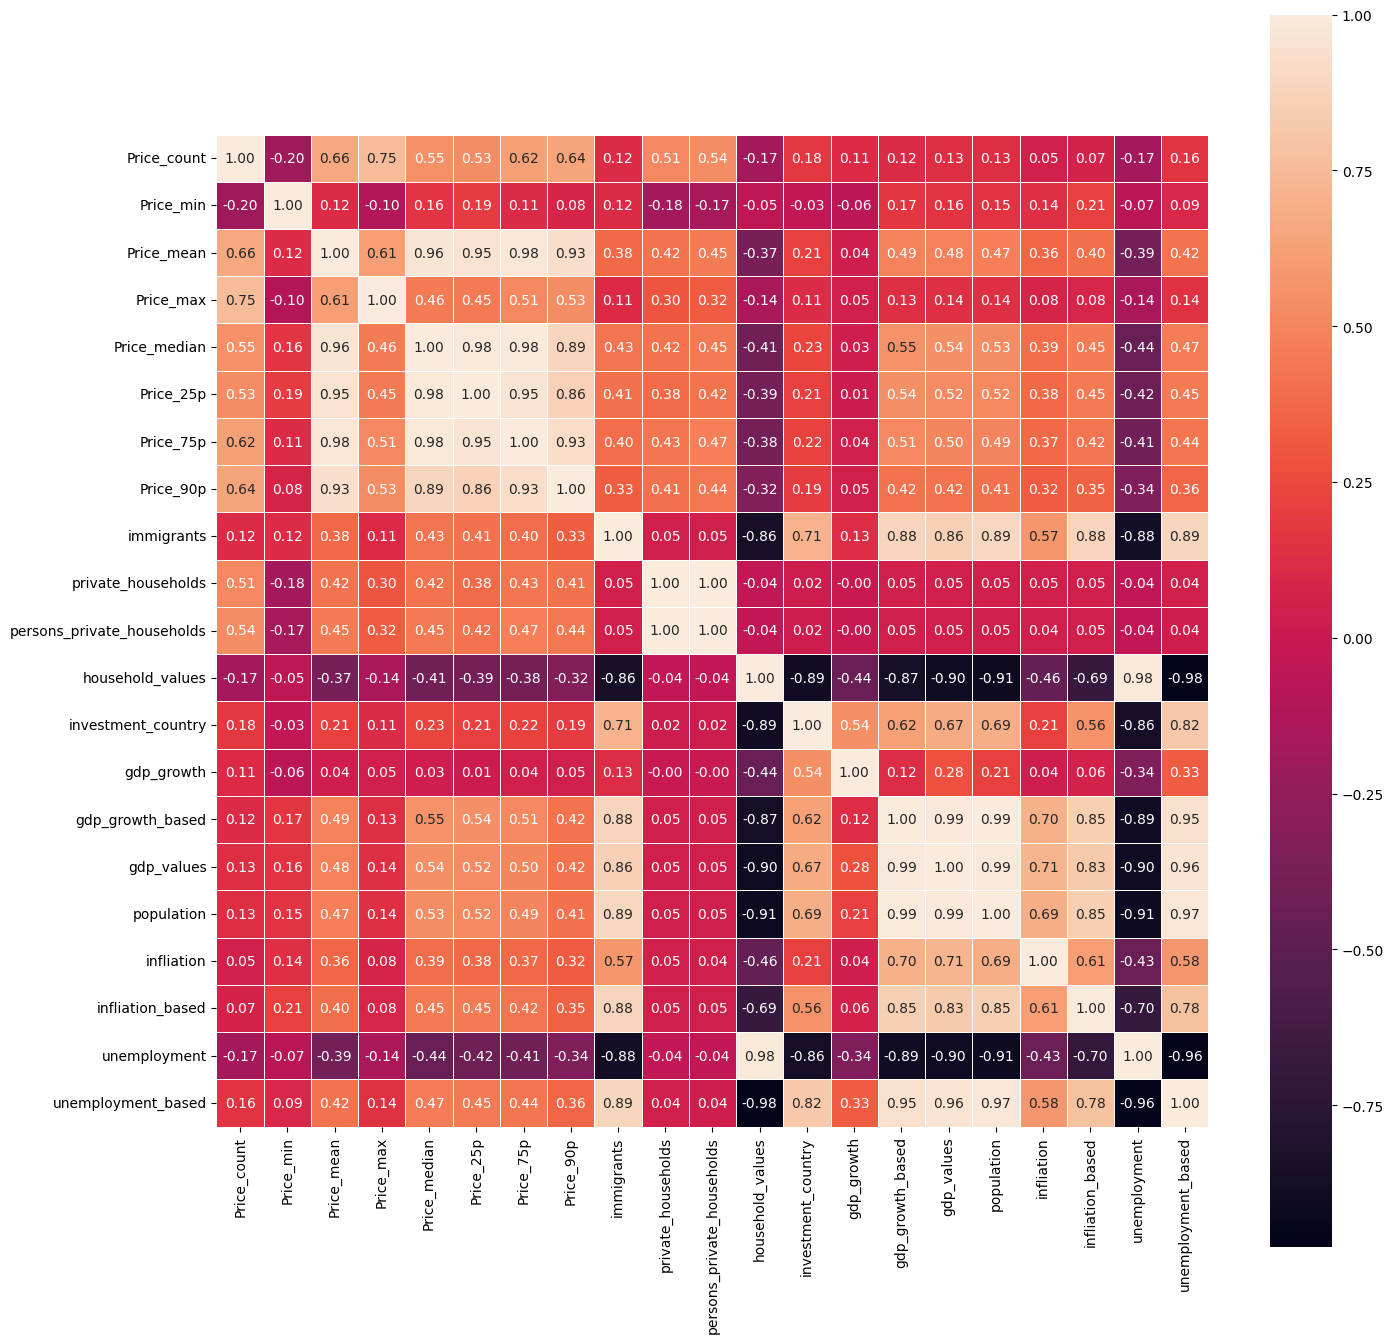

In [50]:
# Correlation of columns
fig, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(merged_dataset.corr(), cbar=True, annot=True, square=True, fmt='.2f', linewidths=.5, ax=ax)
plt.show()

In [51]:
# Pair-wise comparison
sns.pairplot(merged_dataset, size=2, hue='County', palette='hls', diag_kind=None)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [52]:
merged_dataset.to_csv(data_path + '/merged_dataset.csv', encoding='utf-8')